## **What is Financial Sentiment Analysis ?**

Financial Sentiment Analysis (FSA) is the method of classifying financial text or news into positive, negative or neutral sentiments which directly gives the idea of bullish or bearish view of financial market.

### **Challenges in Financial Sentiment Analysis**

Financial sentiment analysis is a challenging tasks as it requires large-scale training data for building machine learning models and difficulty in labelling the financial text as it requires expert knowledge.

Another major challenge with FSA is seriousness of mistakes because analyzing sentiments from movie reviews, product reviews, customer feedbacks, social media posts requires understanding customer feedbacks, aggregating straightforward opinions and some amount of wrong analysis does not make a much difference. Whereas single mistake in sentiment analysis for financial applications may cause huge losses. So, we should very careful in handling exception cases.

After reading this article you will able to classify financial texts into positive, negative or neutral sentiments by training Multinomial Naïve Bayes and Support vector Machine models and can understand the performance difference between TF-IDF and Bag of Words approaches of text representation.

### **Importing Python Libraries**

In the first step, we will import all the necessary python libraries to be required in visualization, data cleaning, machine learning model building and evaluation process.

In [ ]:
# load all necessary libraries
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# libraries for nlp task
import nltk, re, string
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

#machine learning
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import  accuracy_score, f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split,cross_val_score,KFold

# filtering warnings
import warnings
warnings.filterwarnings('ignore')

### **Read Dataset**

After importing all the libraries we have to load the dataset by using pandas library and pandas.read_csv() method.

In [ ]:
# load data
url='finbank_data.csv'
df = pd.read_csv(url,encoding='cp1252')
df.head()

,text,label
0,Cash Flow from Operations for the most recent quarter also reached a eight year low,negative
1,The economic occupancy rate of Sponda 's property portfolio rose to 91.2 % from 88.8 % in 2006,positive
2,The Company operates through four principal divisions : Consumer Packaging ; Office Papers ; Spe...,neutral
3,The contract has been allotted as per lowest price criteria,neutral
4,"The process , technology , project management , basic engineering and quality assurance within F...",neutral


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14780 entries, 0 to 14779
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14780 non-null  object
 1   label   14780 non-null  object
dtypes: object(2)
memory usage: 231.1+ KB


As we can see from the above information that dataset has 14,780 records having non-null entries.

### **Exploratory Data Analysis (EDA)**

In this step, we will analyze the dataset by extracting important information from the financial text.

Firstly, we have to check the distribution of the data.
Target distribution

We can easily plot the distribution of target variable i.e., label in our case by using seaborn library as shown in below code.

<Axes: xlabel='label', ylabel='count'>

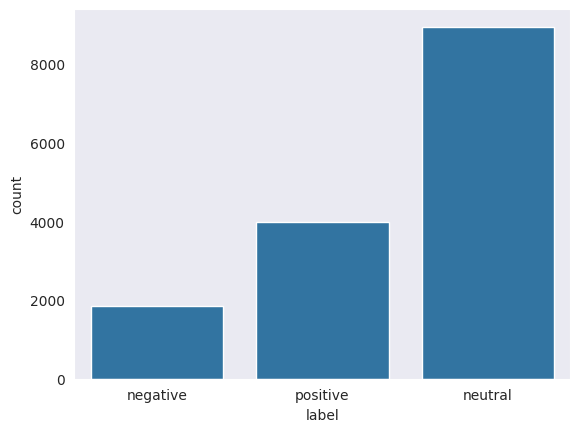

In [ ]:
sns.set_style("dark")
sns.countplot(data=df, x='label')

From the dataset, it is visible that the dataset is highly imbalanced having majority of records with neutral sentiments whereas positive and negative sentiments have lower number of records in the dataset.

So, next we have to balance the dataset and we will do it by down sampling the neutral sentiment and positive sentiment records to the level of negative sentiment records i.e., 2000 so that dataset become balanced and the model will give good performance.

<Axes: xlabel='label', ylabel='count'>

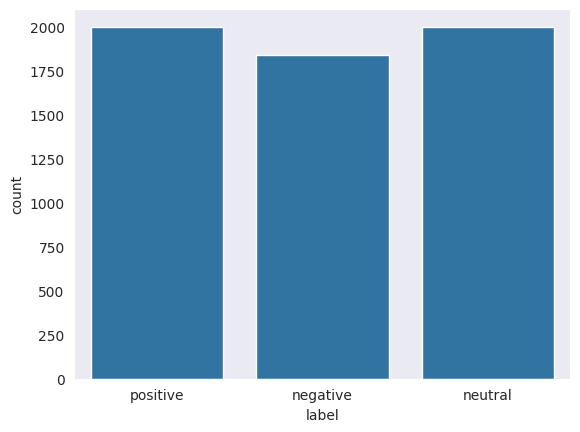

In [ ]:
# taking subset of dataset by downsampling records to 2000
df_pos = df[df['label'] == 'positive'].head(2000)
df_neu = df[df['label']=='neutral'].head(2000)
df_neg = df[df['label']=='negative']

# concatenating the datasets
df_final = pd.concat([df_pos,df_neg],axis=0)
df_final = pd.concat([df_final,df_neu],axis=0)

# checking distribution of target variable in final data
sns.set_style("dark")
sns.countplot(data=df_final, x='label')

As we can see now we have a balanced distribution of all the classes in the dataset.

Next we have to shuffle the dataset as we have concatenated different subset of data and it may contain sequence wise patterns. So for shuffling the dataset we will reindex the data frame using Numpy random permutation.

In [ ]:
df_final = df_final.reindex(np.random.permutation(df_final.index))
df_final.head(10)

,text,label
1150,"According to HKScan Finland , the plan is to increase J+ï¿½rvi-Suomen Portti 's net sales to EUR...",positive
5713,"Thereby , the company will expand its offering to North , Central and South America",positive
5453,"Savon koulutuskuntayhtyma , Finland based company has awarded contract for specialist agricultur...",positive
9884,Operating profit for 2009 lower than outlook published earlier,negative
6383,Finlan 's listed food industry company HKScan Group controlled companies in the Baltics improved...,positive
671,Nordea 's chairman of the board Hans Dalborg has informed the nomination committee that he will ...,neutral
5404,"By combining its existing solutions into a single platform , Comptel said that it has reduced th...",positive
2970,"The company plans to close two of the three lines at the plant , where some 450 jobs are under t...",negative
13126,Profit for the period fell to EUR 1.6 mn from EUR 7.5 mn in January-September 2008,negative
6232,"Fiskars Brands report net sales of EUR 145.8 mn , up from EUR 138.4 mn",positive


After shuffling the dataset, we will calculate the length of the text so that we can do univariate analysis based on different sentiments.

In [ ]:
df_final['length'] = df['text'].apply(len)
df_final.head()

,text,label,length
1150,"According to HKScan Finland , the plan is to increase J+ï¿½rvi-Suomen Portti 's net sales to EUR...",positive,115
5713,"Thereby , the company will expand its offering to North , Central and South America",positive,84
5453,"Savon koulutuskuntayhtyma , Finland based company has awarded contract for specialist agricultur...",positive,121
9884,Operating profit for 2009 lower than outlook published earlier,negative,63
6383,Finlan 's listed food industry company HKScan Group controlled companies in the Baltics improved...,positive,181


Next we will check the overall the distribution of length of the texts in the dataset.

In [ ]:
df_final.length.describe()

count    5841.000000
mean      126.205444
std        55.369672
min        10.000000
25%        82.000000
50%       117.000000
75%       161.000000
max       301.000000
Name: length, dtype: float64

As we can see that the highest length of the message in the dataset is 301 whereas minimum length is 2. the average length of the messages in the dataset is 126.

Now let’s plot the histogram for the length of all the sentiments data.

array([[<Axes: title={'center': 'negative'}>,
        <Axes: title={'center': 'neutral'}>],
       [<Axes: title={'center': 'positive'}>, <Axes: >]], dtype=object)

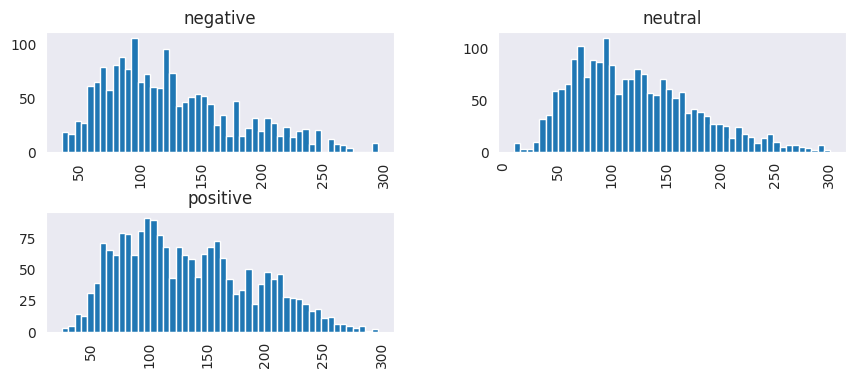

In [ ]:
df_final.hist(column='length', by='label', bins=50,figsize=(10,4))

From the above distribution, we can observe that positive sentiment messages are usually longer in length as they have dense distribution from length 50 to 220 whereas majority of shorter messages of length <=50 belongs to negative sentiment.

### **Word cloud**

Next, we will plot the word cloud so that we can understand the class-wise distribution of words in the dataset. But before plotting word cloud we need to remove stop words so that it can only show significant words in the word cloud.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Text(0.5, 1.0, 'Neutral Sentiment')

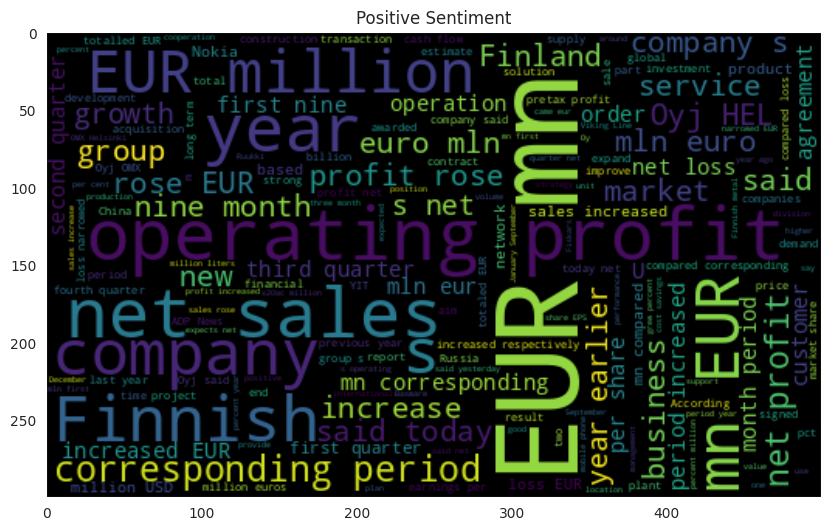

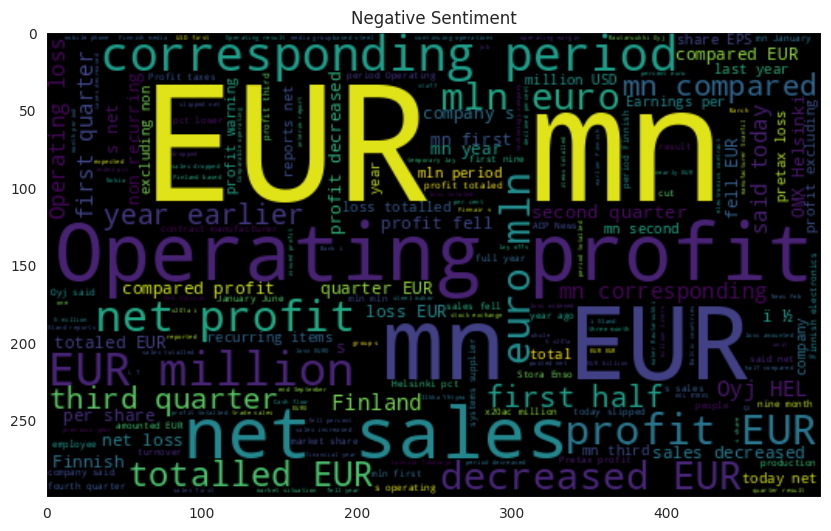

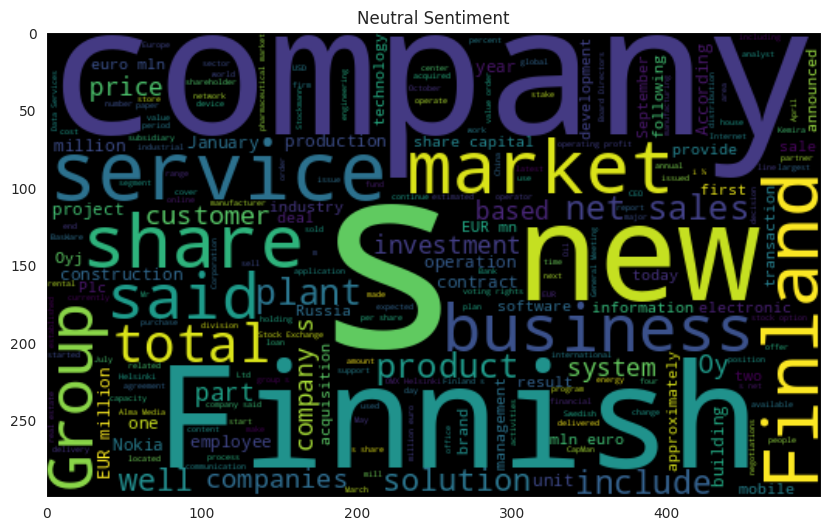

In [ ]:
# creating list of stop words
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

# Removing stop words which are unneccesary from financial text text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

df_pos['text']=df_pos['text'].apply(remove_stopwords)
df_neg['text']=df_neg['text'].apply(remove_stopwords)
df_neu['text']=df_neu['text'].apply(remove_stopwords)

# plotting Positive sentiment wordcloud
plt.figure(figsize = (10,12)) # Text that is Positive sentiment
wc = WordCloud(max_words = 500 , width = 500 , height = 300).generate(" ".join(df_pos.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Positive Sentiment')

# plotting Negative sentiment wordcoud
plt.figure(figsize = (10, 12)) # Text that is Positive sentiment
wc = WordCloud(max_words = 500 , width = 500 , height = 300).generate(" ".join(df_neg.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Negative Sentiment')

# plotting Neutral sentiment wordcoud
plt.figure(figsize = (10,12)) # Text that is Positive sentiment
wc = WordCloud(max_words = 500 , width = 500 , height = 300).generate(" ".join(df_neu.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Neutral Sentiment')

As we can see from above word cloud positive sentiment consists of high frequency words such as operating profit, EUR mn, net sales, profit rose, increased, net profit etc., whereas negative sentiment consists of words such as operating profit, net sales, decreased EUR, EUR mn etc.

### **Data Cleaning and Data preprocessing**

In this step, we will lowercase all the words, remove the stop words, tokenize the text, perform lemmatization, and remove all non-alphabetic characters from the text. The code for the above-mentioned task is shared below:

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
lemma = WordNetLemmatizer()
#creating list of possible stopwords from nltk library
stop = stopwords.words('english')
def cleanText(txt):
  # lowercasing
    txt = txt.lower()

    # tokenization
    words = nltk.word_tokenize(txt)

  # removing stopwords & mennatizing the words
    words = ' '.join([lemma.lemmatize(word) for word in words if word not in (stop)])
    text = "".join(words)

  # removing non-alphabetic characters
    txt = re.sub('[^a-z]',' ',text)
    return txt

#applying cleantweet function on tweet text column
df_final['cleaned_text'] = df_final['text'].apply(cleanText)
df_final.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,text,label,length,cleaned_text
1150,"According to HKScan Finland , the plan is to increase J+ï¿½rvi-Suomen Portti 's net sales to EUR...",positive,115,according hkscan finland plan increase j rvi suomen portti s net sale eur mn eur mn
5713,"Thereby , the company will expand its offering to North , Central and South America",positive,84,thereby company expand offering north central south america
5453,"Savon koulutuskuntayhtyma , Finland based company has awarded contract for specialist agricultur...",positive,121,savon koulutuskuntayhtyma finland based company awarded contract specialist agricultural fores...
9884,Operating profit for 2009 lower than outlook published earlier,negative,63,operating profit lower outlook published earlier
6383,Finlan 's listed food industry company HKScan Group controlled companies in the Baltics improved...,positive,181,finlan s listed food industry company hkscan group controlled company baltic improved revenue e...


From the above output, we can observe that we have cleaned the text and created a separate column named cleaned_text.

Next, we will create a feature and target variable for building a machine learning model as shown in below code, where X denotes textual feature and y denotes class label i.e., sentiments.

In [ ]:
X=df_final.cleaned_text
y = df_final.label

### **Train Test Split**

In this step, we will divide the dataset into train and test set in the ratio of 80:20 i.e., 80% for training the machine learning model and 20% for testing the model. Further we have also applied stratification by which we can maintain the balanced proportion of sentiments in both training and test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,stratify=y, random_state=0)

### **Bag of Words vectorization**

After train test split, we will use bag of words method to vectorize our textual and that is possible in python using CountVectorizer method from sklearn.

In [ ]:
count_vectorizer = CountVectorizer()
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

### **TF-IDF Vectorization**

Next, we will use TF-IDF vectorizer to vectorize our textual data so that later we can compare the performance of machine learning models based on these two approaches i.e., TF-IDF and Bag of Words model.

In [ ]:
# bigrams
tfidf_vectorizer = TfidfVectorizer( max_df=0.8, ngram_range=(1,2))
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

From the above code, we can observe that we are using two parameters i.e., max_df =0.8 and ngram_range=(1,2). The former parameter restricts the vectorizer to use the words which have more than 80% frequency in the document whereas later parameter allowing both unigrams and bi-grams in the data.

Next we will build our machine learning models.

### **Machine Learning Modeling**

In this step, we will fit machine learning models i.e., Multinomial Naïve Bayes and Support Vector Machine on both bag of words and TF-IDF vectorized data.

In [ ]:
# Multinomial Naive bayes bag of words model
mnb_bow = MultinomialNB()
mnb_bow.fit(count_train, y_train)

# Multinomial Naive bayes tf-idf  model
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(tfidf_train, y_train)

#SVM bag of words model
svm_bow =SVC(probability=True,kernel='linear')
svm_bow.fit(count_train, y_train)

# SVM tf-idf model
svm_tfidf = SVC(probability=True,kernel='linear')
svm_tfidf.fit(tfidf_train, y_train)

SVC(kernel='linear', probability=True)

After fitting the machine learning models on both the TF-IDF and Bag of Words vectorized data, we will proceed to cross-validation.

### **Cross validation**

In cross-validation, we usually split the training data into multiple folds and train the model on those folds by setting one fold data for evaluation purpose. Cross-validation helps in detecting overfitting pattern in the data.

In [ ]:
# 10-folds cross validation
kfold = KFold(n_splits=10)
scoring = 'accuracy'
acc_mnb = cross_val_score(estimator = mnb_bow, X = count_train, y = y_train, cv = kfold,scoring=scoring)
acc_svm = cross_val_score(estimator = svm_bow, X = count_train, y = y_train, cv = kfold,scoring=scoring)
acc_mnb_tfidf = cross_val_score(estimator = mnb_tfidf, X = tfidf_train, y = y_train, cv = kfold,scoring=scoring)
acc_svm_tfidf = cross_val_score(estimator = svm_tfidf, X = tfidf_train, y = y_train, cv = kfold,scoring=scoring)

# compare the average 10-fold cross-validation accuracy
crossdict = {
                'MNB-BoW': acc_mnb.mean(),

                'SVM-BoW':acc_svm.mean(),

                'MNB-tfidf': acc_mnb_tfidf.mean(),

                'SVM-tfidf': acc_svm_tfidf.mean(),
                }

cross_df = pd.DataFrame(crossdict.items(), columns=['Model', 'Cross-val accuracy'])
cross_df = cross_df.sort_values(by=['Cross-val accuracy'], ascending=False)
cross_df

,Model,Cross-val accuracy
3,SVM-tfidf,0.881205
1,SVM-BoW,0.855737
2,MNB-tfidf,0.835831
0,MNB-BoW,0.781033


From the above results, it is evident that SVM with TF-IDF achieved highest average 10-fold cross-validation score of 88.46% whereas SVM bag of words achieved a score less than 2% i.e., 85.95%.

### **Model Evaluation**

In this step, we will evaluate both the machine learning models on the test set based on different performance metrics such as accuracy, precision, sensitivity(recall), f1-score, and roc value.

#### **Multinomial Naïve Bayes – Bag of Words Model**

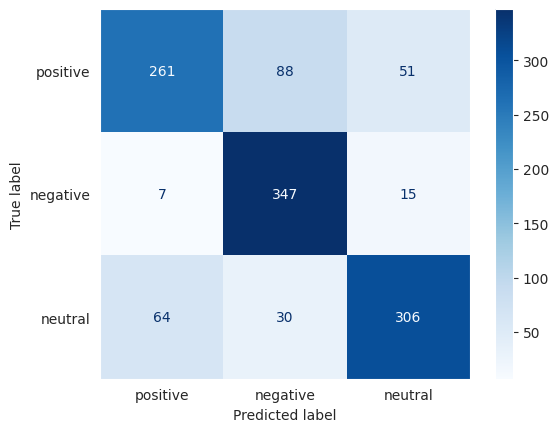

,Model,Accuracy,Precision,Sensitivity,F1 Score
0,Multinomial Naive Bayes-BoW,0.781865,0.784987,0.78596,0.779332


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(cm, classes):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

pred_mnb_bow = mnb_bow.predict(count_test)
acc= accuracy_score(y_test, pred_mnb_bow)
prec = precision_score(y_test, pred_mnb_bow,pos_label='positive',
                                           average='macro')
rec = recall_score(y_test, pred_mnb_bow,pos_label='positive',
                                           average='macro')
f1 = f1_score(y_test, pred_mnb_bow,pos_label='positive',
                                           average='macro')
cm = confusion_matrix(y_test, pred_mnb_bow, labels=['positive', 'negative','neutral'])
plot_confusion_matrix(cm, classes=['positive', 'negative','neutral'])
model_results =pd.DataFrame([['Multinomial Naive Bayes-BoW',acc, prec,rec,f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity', 'F1 Score'])
model_results

The model has achieved an accuracy of 79.89% whereas sensitivity and precision is slightly higher than accuracy. The main issue with this model is that it has detected 67 positive sentiment cases as negative while 63 as neutral whereas model has done pretty well in detecting negative sentiment cases.

Next, we will define one function for evaluating the machine learning model so that we don’t have to write same code for evaluation again and again.

In [ ]:
def evaluate_model(model,model_name,test_set,model_results):
    pred = model.predict(test_set)
    acc= accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred,pos_label='positive',
                                               average='macro')
    rec = recall_score(y_test, pred,pos_label='positive',
                                               average='macro')
    f1 = f1_score(y_test, pred,pos_label='positive',
                                               average='macro')
    cm = confusion_matrix(y_test, pred, labels=['positive', 'negative','neutral'])
    plot_confusion_matrix(cm, classes=['positive', 'negative','neutral'])
    results =pd.DataFrame([[model_name,acc, prec,rec,f1]],
                   columns = ['Model', 'Accuracy','Precision', 'Sensitivity', 'F1 Score'])
    return results

#### **SVM - Bag of Words Model**

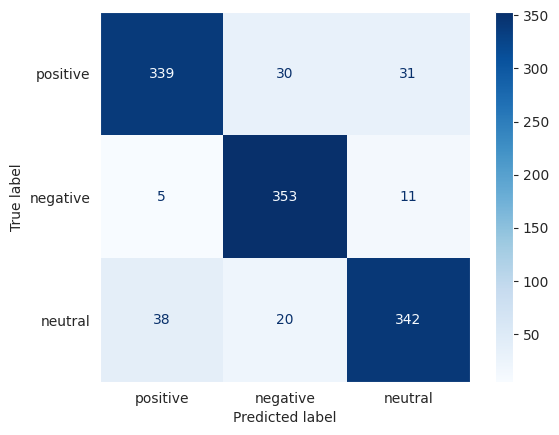

,Model,Accuracy,Precision,Sensitivity,F1 Score
0,SVM-BoW,0.884517,0.884663,0.88638,0.884655


In [ ]:
model_results = evaluate_model(svm_bow,'SVM-BoW',count_test,model_results)
model_results

SVM with bag of words has done a pretty good job in comparison to Naïve Bayes model as it bring downs the number of misclassification rate for positive and neutral sentiment cases whereas sensitivity for negative sentiment is very high only 9 misclassified cases out of total 369.

#### **Multinomial Naïve Bayes – TF-IDF Model**

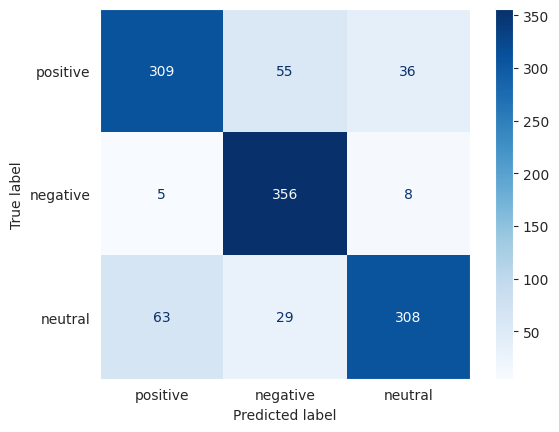

,Model,Accuracy,Precision,Sensitivity,F1 Score
0,MNB-TF-IDF,0.832335,0.834573,0.835757,0.831538


In [ ]:
model_results = evaluate_model(mnb_tfidf,'MNB-TF-IDF',tfidf_test,model_results)
model_results

As we can see from above result that Naïve Bayes model with TF-IDF performed way better than bag of words model and attained higher accuracy of 86.05% which is 7% higher than bag of word model.

Atlast, we will check the performance of SVM on TF-IDF vectorized data.

#### **SVM - TF-IDF Model**

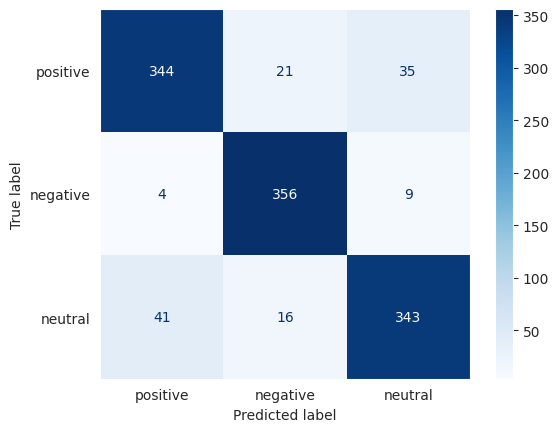

,Model,Accuracy,Precision,Sensitivity,F1 Score
0,SVM-TF-IDF,0.892216,0.892159,0.89409,0.892679


In [ ]:
model_results = evaluate_model(svm_tfidf,'SVM-TF-IDF',tfidf_test,model_results)
model_results

From the above results, it is evident that SVM with TFIDF performed best among all the models with an accuracy of 90.76% and sensitivity for all the three classes are more than 90%.

Next, we will use our best model i.e., SVM TF-IDF to do prediction on sample sentences.

#### **Sample Prediction**

So, for doing the prediction on real-time textual data, firstly we have to preprocess the data and then transform it into vectorized format using TF-IDF vectorizer.

In [ ]:
def predict_text(lst_text,model):
    df_test = pd.DataFrame(lst_text, columns = ['test_sent'])

    # apply data preprocessing
    df_test["test_sent_cleaned"] = df_test["test_sent"].apply(cleanText)

    # transforming text into tf-idf vectorized format
    tfidf_bigram = tfidf_vectorizer.transform(lst_text)

    # model prediction
    prediction = model.predict(tfidf_bigram)

    # saving prediction in dataframe by creation prediction column
    df_test['prediction']=prediction

    # subset dataframe to include only original entences and model prediction
    df_test = df_test[['test_sent','prediction']]

    return df_test

sentences = [
  "Operating profit declined by 27 % to EUR 579.8 mn from EUR 457.2 mn in 2006",
    "This new partnership agreement achieved a significant milestone for both parties",
    "For around 3 years business remains same"


  ]
predict_text(sentences,svm_tfidf)

,test_sent,prediction
0,Operating profit declined by 27 % to EUR 579.8 mn from EUR 457.2 mn in 2006,negative
1,This new partnership agreement achieved a significant milestone for both parties,positive
2,For around 3 years business remains same,neutral


### **Conclusion**

So, in this project we have built machine learning model for predicting sentiments of financial textual data. In the project we have used Financial PhraseBank dataset for building the machine learning model and compared both bag of words and TF-IDF vectorization approaches. In the end, we found that SVM with TF-IDF vectorizer outperformed other models and attained more than 90% accuracy, precision and recall. Further we have used the best model to perform sample prediction in which the model has done accurate prediction for all the three sentiments.